# What Do You Know? Dataset 

## Dataset Characteristics

**Has GROUPING field**

* Tags would be available for each question

## Preliminaries

### Constants

In [1]:
# paths
PATH_TO_INTERACTION_DATA = '../../../../../data/WhatDoYouKnow/grockit_all_data/training.csv'
PATH_TO_CATEGORY_LABEL_DATA = '../../../../../data/WhatDoYouKnow/grockit_all_data/category_labels.csv' 

# dataset name
DATASET_NAME = 'what_do_you_know'

# fields used in the analysis
USER_FIELD = 'user_id'
GROUP_FIELD = 'track_name'
LEARNING_ACTIVITY_FIELD = 'question_id'

# fields used in dataset preparation
TIMESTAMP_FIELD = 'round_started_at'

### Import Packages

In [2]:
from utilities.sequence_similarity import *
from utilities.sequence_similarity_no_group import *
from utilities.functions import *
from utilities.constants import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import textdistance as td
import pickle

### Seaborn Configuration

In [3]:
sns.set(rc = {'figure.figsize':(15,8)})

In [4]:
#sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":20, "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":20, "legend.title_fontsize":20})   

In [5]:
sns.set_style("darkgrid")

In [6]:
marker_config = {"marker":"o",
                 "markerfacecolor":"white", 
                 "markeredgecolor":"black",
                 "markersize":"10"}

### Import Pickled Objects

In [7]:
# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'rb') as f:
#     seq_dist_per_group_dict = pickle.load(f)

# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, 'rb') as f:
#     seq_dist_dict = pickle.load(f)

## Functions

In [8]:
def map_tags(x, mapping_dict):
    tag_list = x.split(' ')
    tag_list_mapped = []
    for tag in tag_list:
        tag_list_mapped.append(mapping_dict[tag])
    
    return tag_list_mapped

## Dataset Preparation

### Import Data

In [9]:
interactions = pd.read_csv(PATH_TO_INTERACTION_DATA)
category_labels = pd.read_csv(PATH_TO_CATEGORY_LABEL_DATA)

In [10]:
interactions['round_started_at'] = pd.to_datetime(interactions['round_started_at'], errors='coerce')
interactions['answered_at'] = pd.to_datetime(interactions['answered_at'], errors='coerce')
interactions['deactivated_at'] = pd.to_datetime(interactions['deactivated_at'], errors='coerce')

In [11]:
interactions

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaT,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaT,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaT,2010-04-19 23:14:35,25553,7,5,NaN,470


In [ ]:
category_labels

### Merge and Filter Data

In [12]:
mapping_dict = {}
for field, df in category_labels.groupby('field'):
    mapping_dict[field] = dict(zip(df.id.apply(str), df.label))

for column in mapping_dict.keys():
    if column == 'tag_string':
        interactions[column] = interactions[column].apply(lambda x: map_tags(str(x), mapping_dict[column]))
    else:
        interactions[column] = interactions[column].apply(lambda x: mapping_dict[column][str(x)])

### Filter Sequences by NAs in Dataset 

In [13]:
# only timestamps contain NAs
pct_na = get_nas_in_data(interactions)
pct_na

correct                               0.0 %
outcome              0.005214908867921611 %
user_id                               0.0 %
question_id                           0.0 %
question_type                         0.0 %
group_name                            0.0 %
track_name                            0.0 %
subtrack_name                         0.0 %
tag_string                            0.0 %
round_started_at    0.0014222478730695305 %
answered_at             11.46224601796361 %
deactivated_at      0.0020612288015500442 %
answer_id                             0.0 %
game_type            0.007976955461998671 %
num_players                           0.0 %
date_of_test             78.8256767271809 %
question_set_id                       0.0 %
dtype: object

In [14]:
interactions = drop_na_by_fields(interactions, field_list=[GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD])

Input length: 4851475
Outpunt length: 4851406
Number of rows removed: 69
Percentage of rows removed: 0%


### Sort by Timestamp

In [15]:
interactions = sort_by_timestamp(interactions, TIMESTAMP_FIELD, higher_level_sort_list=[GROUP_FIELD, USER_FIELD])

### Transform Data

In [16]:
interactions = keep_last_repeated_learning_activities(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD)

100%|██████████| 238927/238927 [00:47<00:00, 5051.00it/s]


Initial number of interactions: 4851406
Final number of interactions: 4815928
Removed number of interactions: 35478
Removed percentage of interactions: 0.7312931550152678%


## Summary Statistics and Plots 

In [17]:
print_summary_stats(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, USER_FIELD_NAME_STR, GROUP_FIELD_NAME_STR, LEARNING_ACTIVITY_FIELD_NAME_STR, has_group_field=True)

number of interactions: 4815928
number of unique Topics: 9
number of unique Users: 179096
number of unique Learnig Resources: 6045


### Dataset Specific Characteristics

### Interactions per User

In [18]:
interactions_per_user = print_and_return_interactions_per_user(interactions, USER_FIELD, USER_FIELD_NAME_STR)

mean number of interactions per User: 26.89020413632912
median number of interactions per User: 6.0
max number of interactions per User: 10032
min number of interactions per User: 1


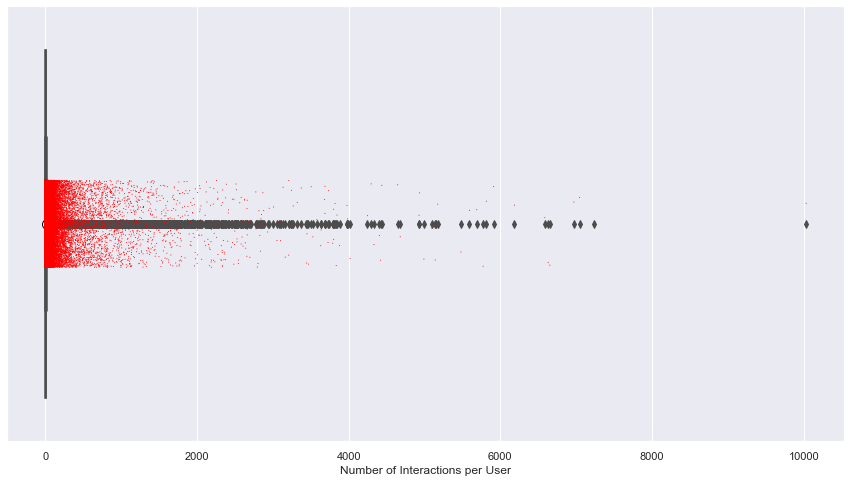

In [19]:
g = sns.boxplot(data=interactions_per_user, x='number of interactions', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=interactions_per_user, x='number of interactions', size=1, color="red");
g.set(xlabel='Number of Interactions per User');

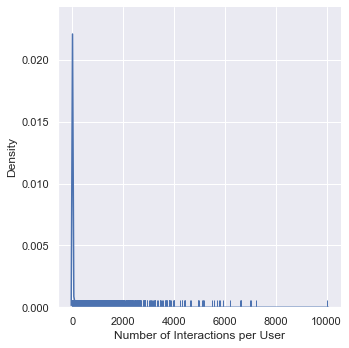

In [20]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='kde', rug=True)
g.set(xlabel='Number of Interactions per User');

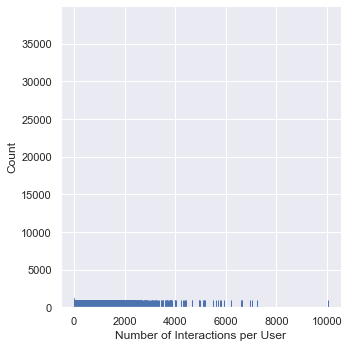

In [21]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel='Number of Interactions per User');

### Number of Unique Groups per User

In [22]:
n_unique_groups_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, GROUP_FIELD, NUMBER_UNIQUE_GROUPS_PER_USER_STR)

mean Number of Unique Topics per User: 1.3340722294188592
median Number of Unique Topics per User: 1.0
max Number of Unique Topics per User: 9
min Number of Unique Topics per User: 1


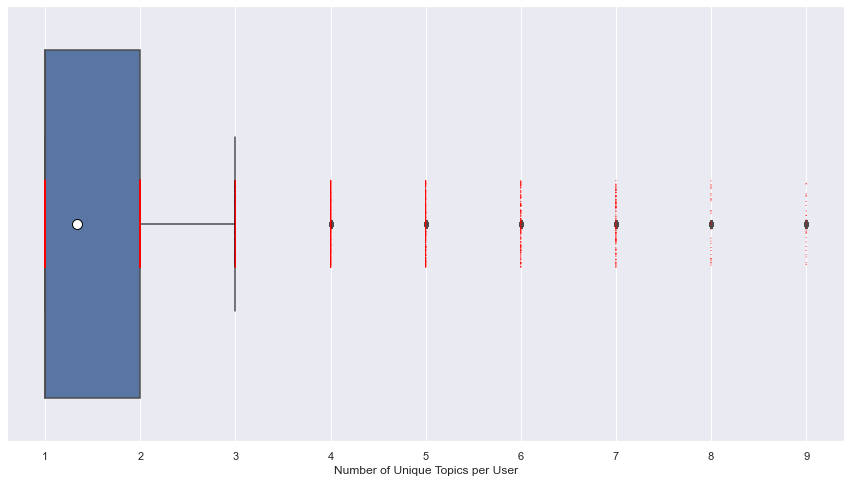

In [23]:
g = sns.boxplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

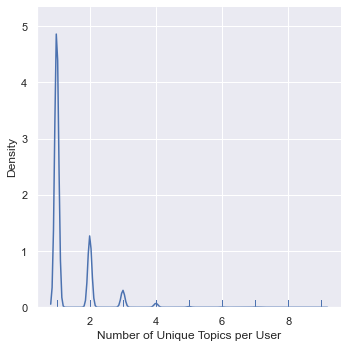

In [24]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

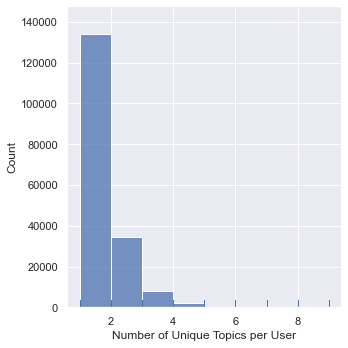

In [25]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

### Number of Unique Learning Activities per User

In [26]:
n_unique_learning_activities_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR)

mean Number of Unique Learnig Resources per User: 23.5630667351588
median Number of Unique Learnig Resources per User: 6.0
max Number of Unique Learnig Resources per User: 2352
min Number of Unique Learnig Resources per User: 1


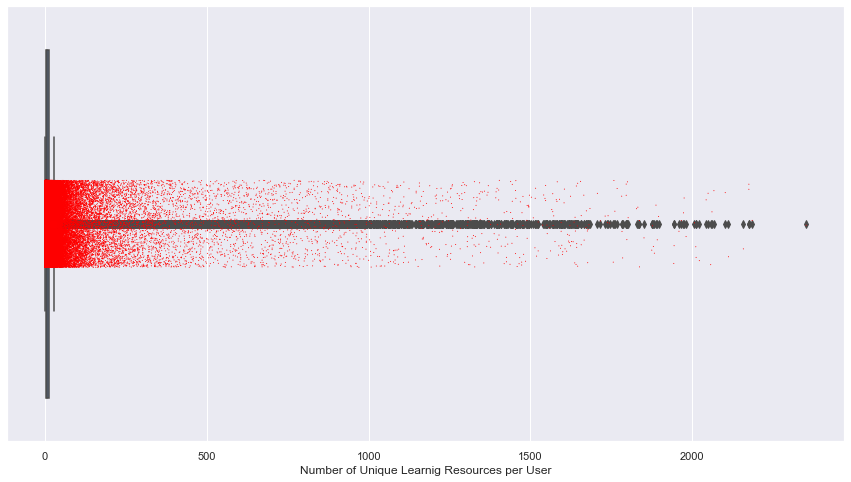

In [27]:
g = sns.boxplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

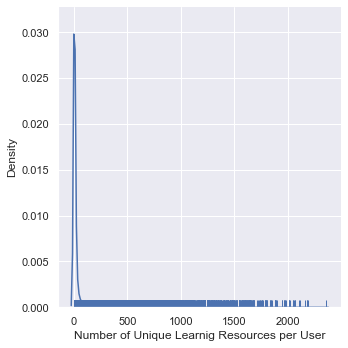

In [28]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

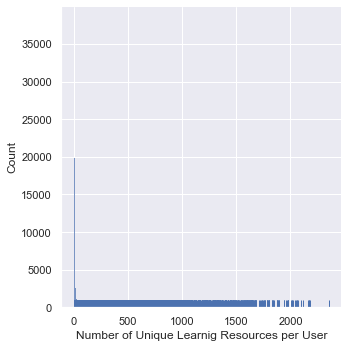

In [29]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

### Number of Unique Users per Group

In [30]:
n_unique_users_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_GROUP_STR)

mean Number of Unique Users per Topic: 26547.444444444445
median Number of Unique Users per Topic: 23734.0
max Number of Unique Users per Topic: 51612
min Number of Unique Users per Topic: 7760


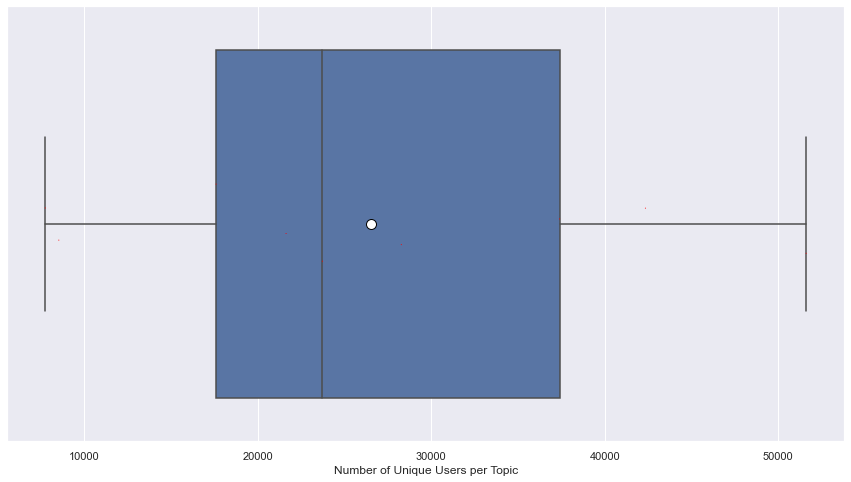

In [31]:
g = sns.boxplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

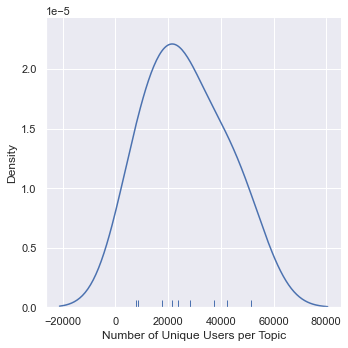

In [32]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

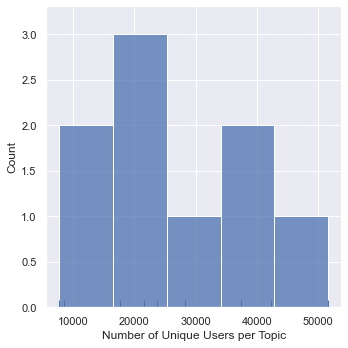

In [33]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

### Number of Unique Learning Activities per Group

In [34]:
n_unique_learning_activities_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR)

mean Number of Unique Learnig Resources per Topic: 671.6666666666666
median Number of Unique Learnig Resources per Topic: 651.0
max Number of Unique Learnig Resources per Topic: 1168
min Number of Unique Learnig Resources per Topic: 232


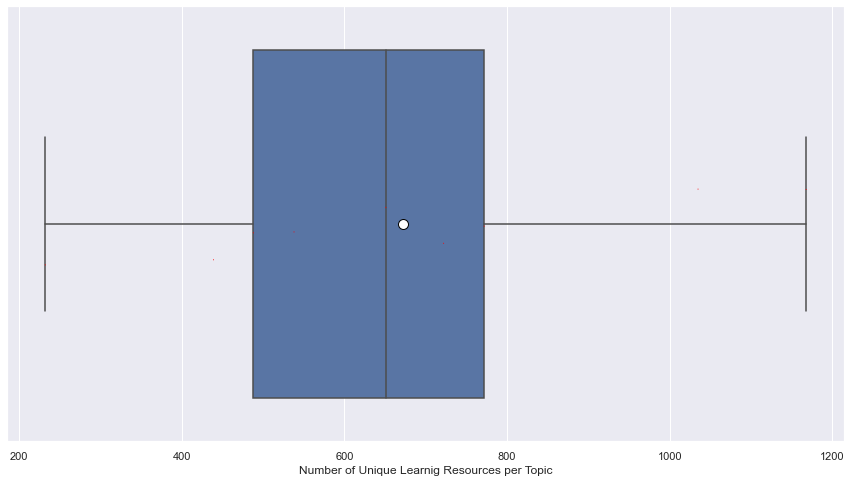

In [35]:
g = sns.boxplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

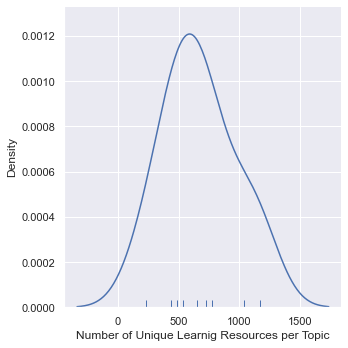

In [36]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

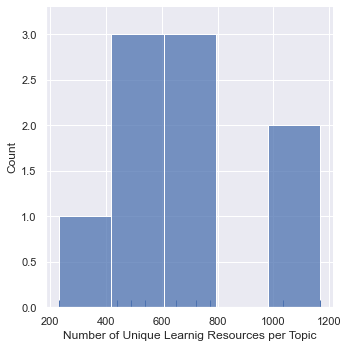

In [37]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

### Number of Unique Users per Learning Activity

In [38]:
n_unique_users_per_learning_activity = print_and_return_unique_col2_per_col1(interactions, LEARNING_ACTIVITY_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR)

mean Number of Unique Users per Learnig Resource: 698.1060380479736
median Number of Unique Users per Learnig Resource: 528.0
max Number of Unique Users per Learnig Resource: 14063
min Number of Unique Users per Learnig Resource: 2


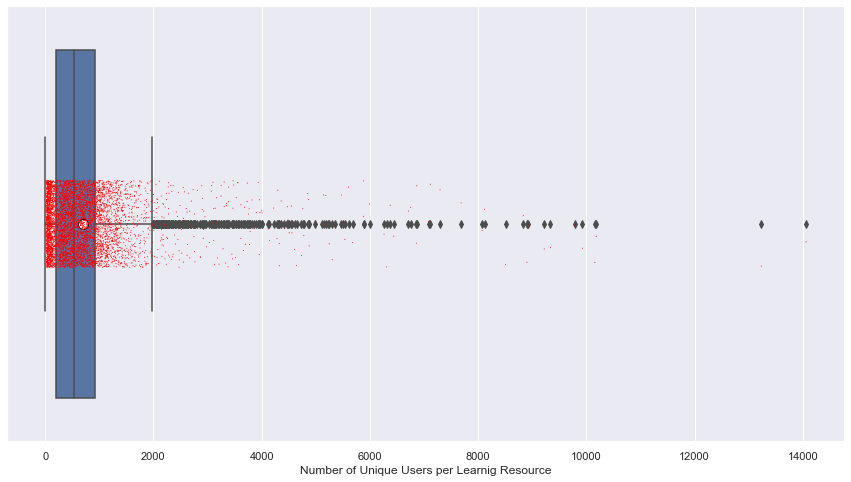

In [39]:
g = sns.boxplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

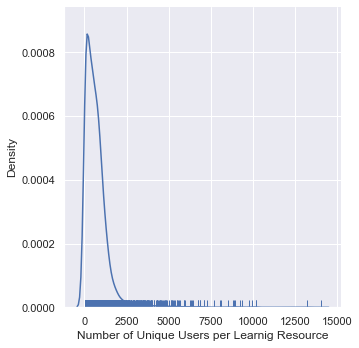

In [40]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

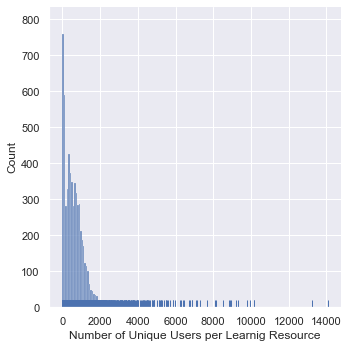

In [41]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

### Avg Number of Interactions over Groups for a User (User Sequence Length)

In [42]:
mean_n_interactions_over_groups, median_n_interactions_over_groups = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR)

mean of Mean Number of Interactions over Topics for a User: 14.086374466367559
median of Mean Number of Interactions over Topics for a User: 5.0
max of Mean Number of Interactions over Topics for a User: 3315.5
min of Mean Number of Interactions over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Interactions over Topics for a User: 13.495105976682897
median of Median Number of Interactions over Topics for a User: 5.0
max of Median Number of Interactions over Topics for a User: 3315.5
min of Median Number of Interactions over Topics for a User: 1.0


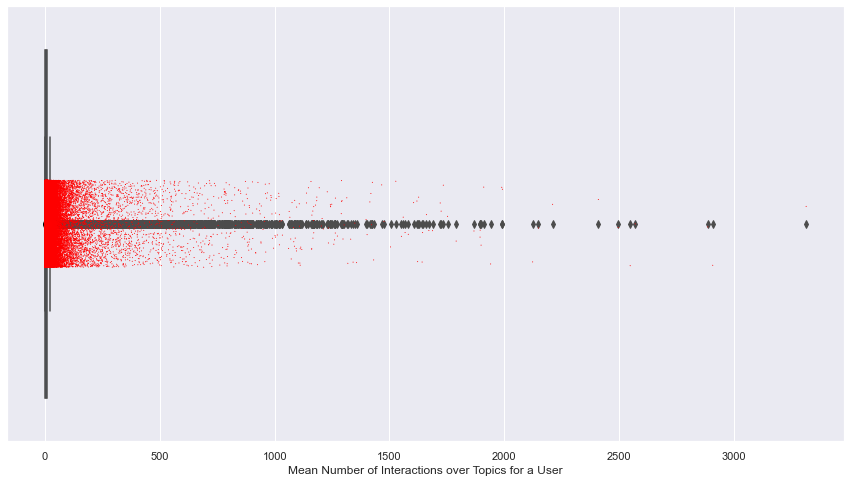

In [43]:
g = sns.boxplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

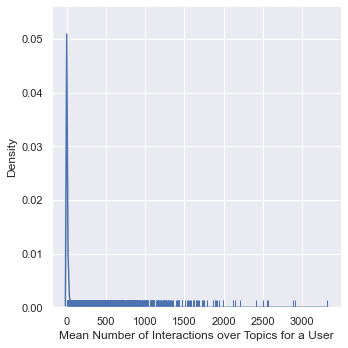

In [44]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

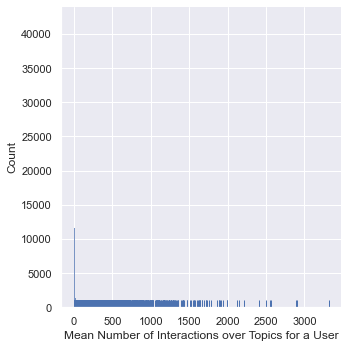

In [45]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

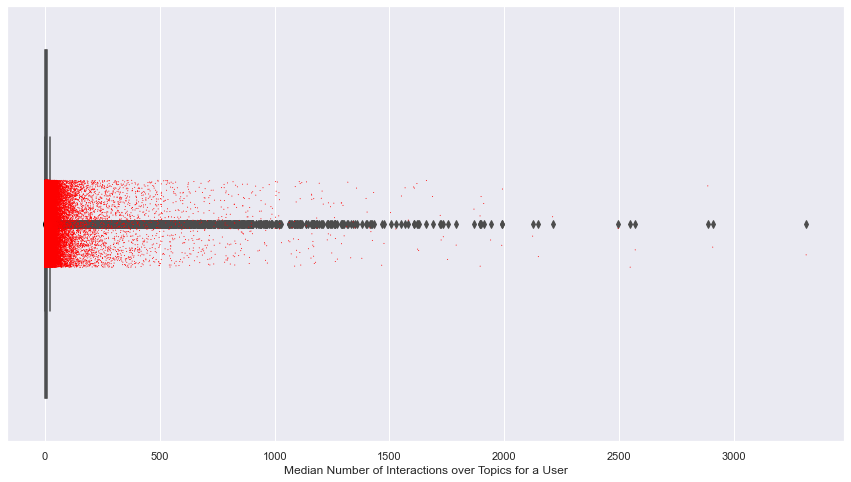

In [46]:
g = sns.boxplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

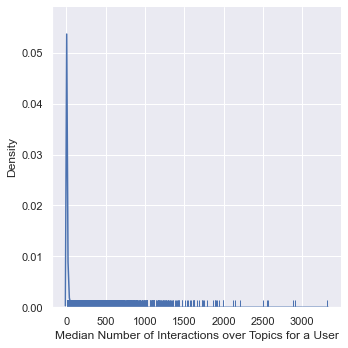

In [47]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

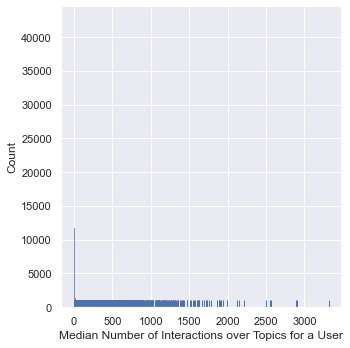

In [48]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

### Avg Number of Interactions over Users for a Group (Group Sequence Length)

In [49]:
mean_n_interactions_over_users, median_n_interactions_over_users = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR)

mean of Mean Number of Interactions over Users for a Topic: 17.790960610623618
median of Mean Number of Interactions over Users for a Topic: 16.900176442281985
max of Mean Number of Interactions over Users for a Topic: 28.93591196750732
min of Mean Number of Interactions over Users for a Topic: 10.092783505154639

__________________________________________________

mean of Median Number of Interactions over Users for a Topic: 5.222222222222222
median of Median Number of Interactions over Users for a Topic: 5.0
max of Median Number of Interactions over Users for a Topic: 6.0
min of Median Number of Interactions over Users for a Topic: 4.0


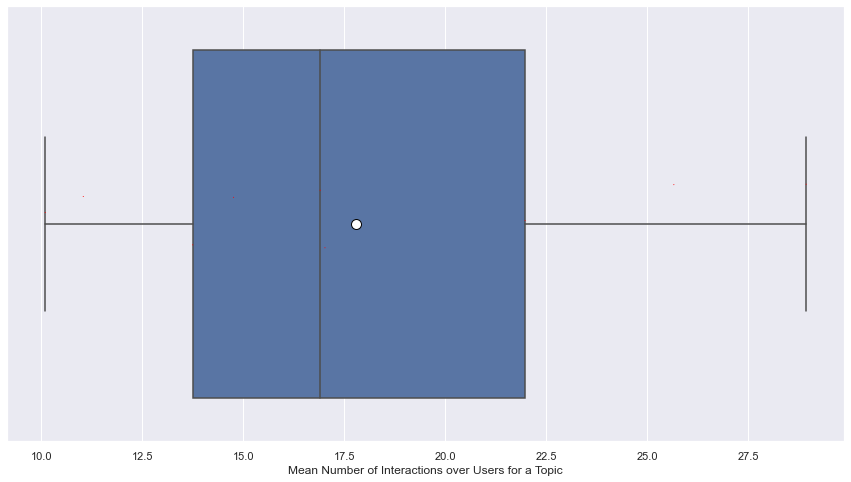

In [50]:
g = sns.boxplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

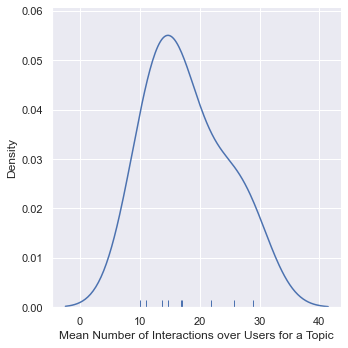

In [51]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

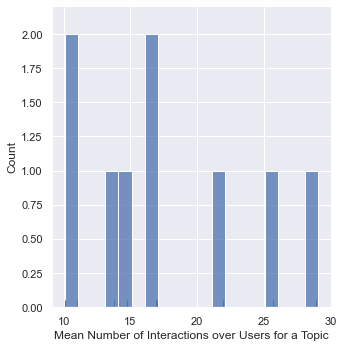

In [52]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

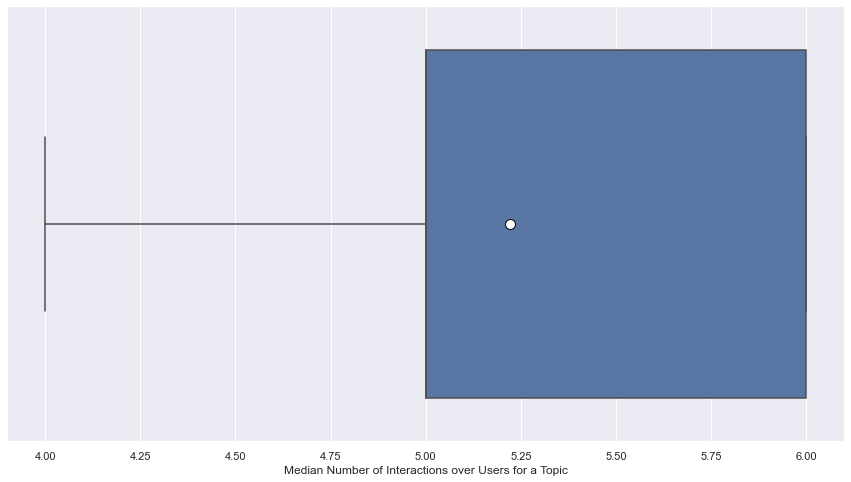

In [53]:
g = sns.boxplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

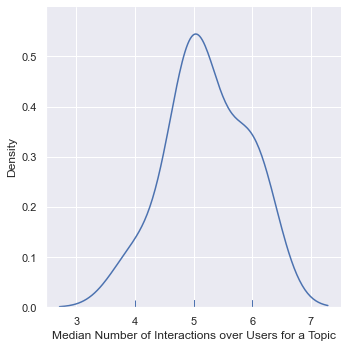

In [54]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

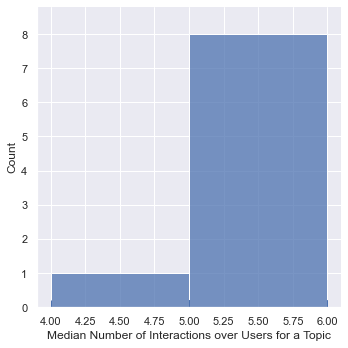

In [55]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

### Avg Number of Unique Learning Activities over Groups for a User

In [56]:
mean_n_unique_learning_activities_over_groups_for_user, median_n_unique_learning_activities_over_groups_for_user = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR)

mean of Mean Number of Unique Learnig Resources over Topics for a User: 12.826866627705527
median of Mean Number of Unique Learnig Resources over Topics for a User: 5.0
max of Mean Number of Unique Learnig Resources over Topics for a User: 1092.5
min of Mean Number of Unique Learnig Resources over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Unique Learnig Resources over Topics for a User: 12.473098226649395
median of Median Number of Unique Learnig Resources over Topics for a User: 5.0
max of Median Number of Unique Learnig Resources over Topics for a User: 1092.5
min of Median Number of Unique Learnig Resources over Topics for a User: 1.0


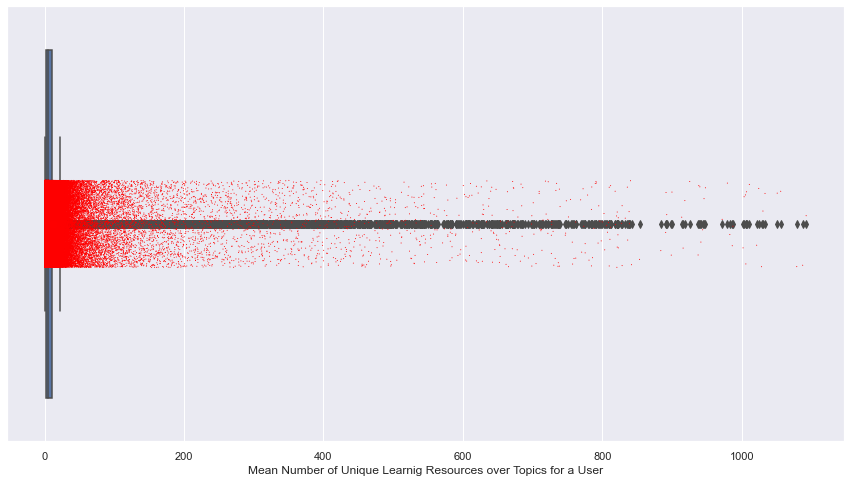

In [57]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

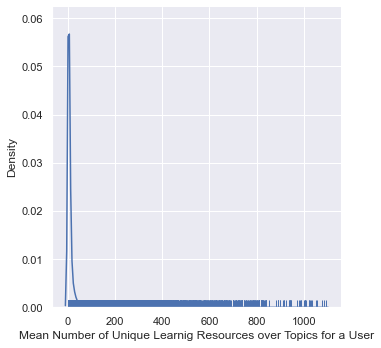

In [58]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

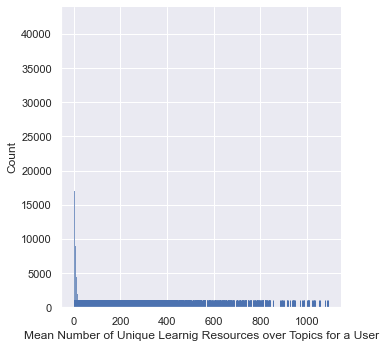

In [59]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

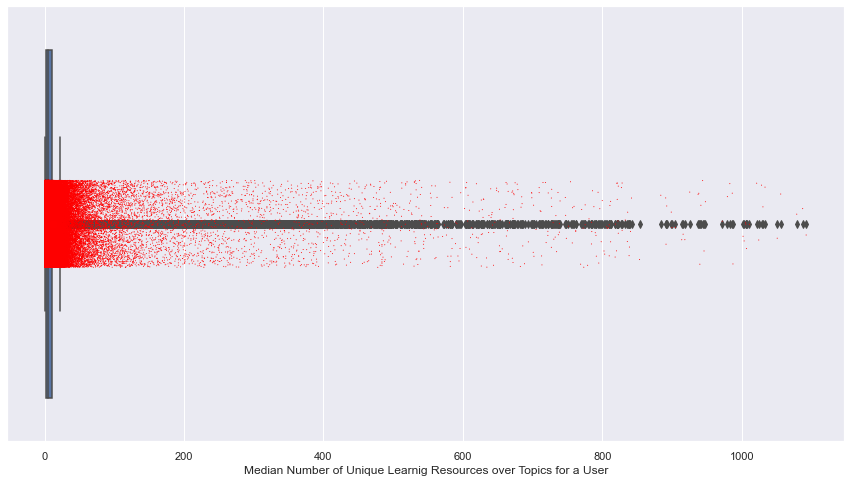

In [60]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

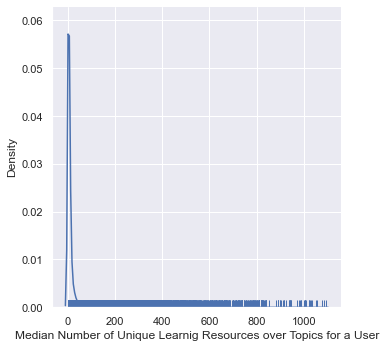

In [61]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

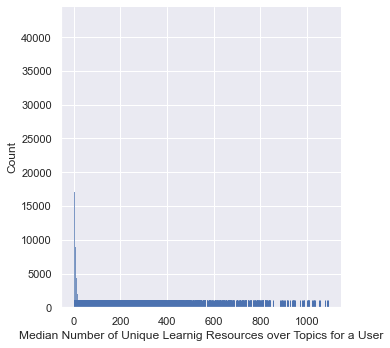

In [62]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

### Avg Number of Unique Learning Activities over Users for a Group

In [63]:
mean_n_unique_learning_activities_over_users_for_group, median_n_unique_learning_activities_over_users_for_group = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR)

mean of Mean Number of Unique Learnig Resources over Users for a Topic: 15.770741836330611
median of Mean Number of Unique Learnig Resources over Users for a Topic: 14.45535475592151
max of Mean Number of Unique Learnig Resources over Users for a Topic: 25.1889817700954
min of Mean Number of Unique Learnig Resources over Users for a Topic: 9.76340206185567

__________________________________________________

mean of Median Number of Unique Learnig Resources over Users for a Topic: 5.222222222222222
median of Median Number of Unique Learnig Resources over Users for a Topic: 5.0
max of Median Number of Unique Learnig Resources over Users for a Topic: 6.0
min of Median Number of Unique Learnig Resources over Users for a Topic: 4.0


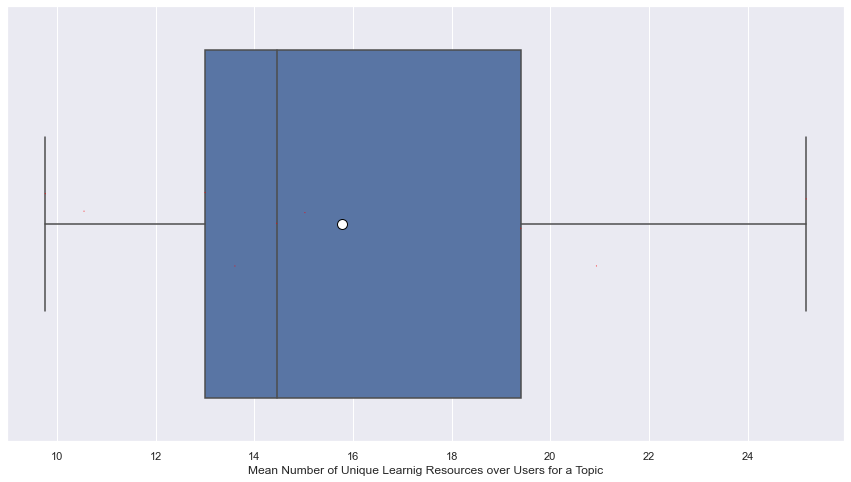

In [64]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

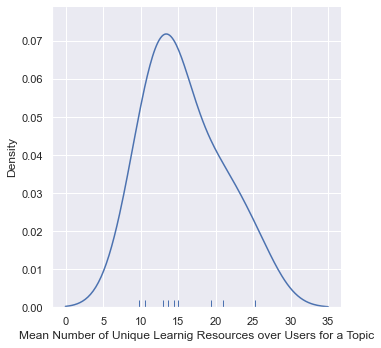

In [65]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

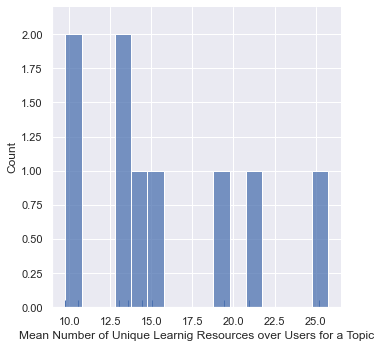

In [66]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

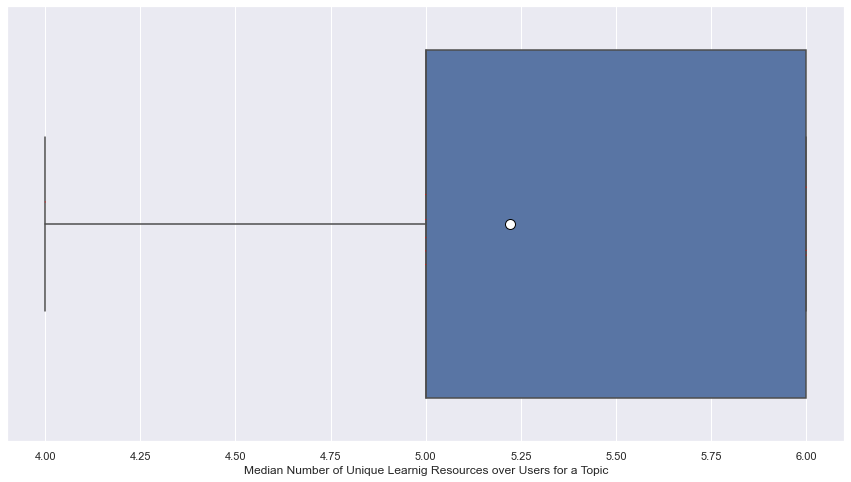

In [67]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

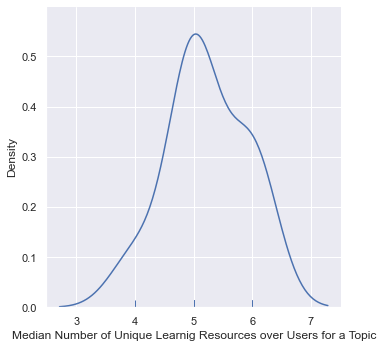

In [68]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

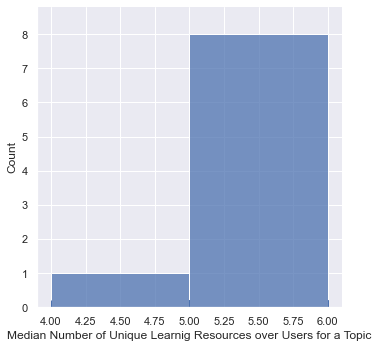

In [69]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

### Sparsity - User_Item_Matrix

#### User-Group

In [70]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[GROUP_FIELD])
print(f"User-{GROUP_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Topic Sparsity: 85.17697522867934 %


#### User-Learning Activity

In [71]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[LEARNING_ACTIVITY_FIELD])
print(f"User-{LEARNING_ACTIVITY_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Learnig Resource Sparsity: 99.610205678492 %


## Unique Sequence Statistics

### Unique User Sequence Statistics per Group

In [ ]:
learning_activity_sequence_stats_per_group = return_col3_sequence_stats_over_col2_per_col1(interactions, 
                                                                                           GROUP_FIELD, 
                                                                                           USER_FIELD, 
                                                                                           LEARNING_ACTIVITY_FIELD,
                                                                                           TIMESTAMP_FIELD,
                                                                                           GROUP_FIELD_NAME_STR,
                                                                                           GROUP_CODE_FIELD_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_CODE_FIELD_NAME_STR, 
                              LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_PER_GROUP_TITLE_NAME_STR)

### Unique User Sequence Statistics

In [ ]:
learning_activity_sequence_stats = return_col2_sequence_stats_over_col1(interactions, 
                                                                        USER_FIELD, 
                                                                        LEARNING_ACTIVITY_FIELD,
                                                                        TIMESTAMP_FIELD,
                                                                        LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats(learning_activity_sequence_stats,
                    LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_TITLE_NAME_STR)

## Sequence Distance

### Sequence Distance between Users per Group

In [ ]:
seq_sim = SeqSim(interactions.head(100000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_per_group_dict = seq_sim.get_user_sequence_distances_per_group(td.levenshtein.distance, sample_pct=80, sample_pct_user=10)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'wb') as f:
    pickle.dump(seq_dist_per_group_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
avg_seq_dist_per_group_df = get_avg_seq_dist_per_group_df(seq_dist_per_group_dict)

In [ ]:
avg_seq_dist_per_group_df

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_distance', size=5, color="red");
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_distance', size=5, color="red");
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', size=5, color="red");
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', size=5, color="red");
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

### Sequence Distance between Users 

In [ ]:
seq_sim = SeqSim(interactions.head(50000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_dict = seq_sim.get_user_sequence_distances(td.levenshtein.distance, sample_pct=20)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, "wb") as f:
    pickle.dump(seq_dist_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
seq_dist_df = get_seq_dist_df(seq_dist_dict)

In [ ]:
seq_dist_df

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='distance', size=5, color="red");
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='normalized_distance', size=5, color="red");
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_normalized_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');